In [1]:
import logging
import threading
import itertools
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
import seaborn as seabornInstance
from sqlalchemy import Column, Integer, String, Float, DateTime, Boolean, func
from iotfunctions import base
from iotfunctions import bif
from iotfunctions import entity
from iotfunctions import metadata
from iotfunctions.metadata import EntityType
from iotfunctions.db import Database
from iotfunctions.enginelog import EngineLogging
from iotfunctions import estimator
from iotfunctions.ui import (UISingle, UIMultiItem, UIFunctionOutSingle,
                 UISingleItem, UIFunctionOutMulti, UIMulti, UIExpression,
                 UIText, UIStatusFlag, UIParameters)
import datetime as dt
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import scipy as sp
import scipy.fftpack
import skimage as ski  
from skimage import util as skiutil # for nifty windowing
import pyod as pyod
from pyod.utils.data import generate_data
from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize
from pyod.models.knn import KNN
from pyod.models.iforest import IForest
%matplotlib inline

/home/markus/.local/lib/python3.7/site-packages/iotfunctions/bif.py:1899: UserWarning: IoTCalcSettings is deprecated. Use entity type constants instead of a metadata provider to set entity type properties
  warnings.warn(('IoTCalcSettings is deprecated. Use entity type constants'
/home/markus/.local/lib/python3.7/site-packages/numba/errors.py:131: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


In [2]:
credentials = {
  "tenantId": "AnalyticsServiceDev",
  "as_api_host": "https://api-dev.connectedproducts.internetofthings.ibmcloud.com",
  "as_api_key": "a-69xgm4-8bdgtvnsv4",
  "as_api_token": "9X_tMKdupOiJ!mzaPV",
  "config" : {
      "objectStorageEndpoint" : "https://s3-api.us-geo.objectstorage.softlayer.net",
      "bos_runtime_bucket" : "analytics-runtime-analyticsservicedev-799d2008b460",
      "bos_logs_bucket" : "analytics-logs-analyticsservicedev-32703c52ec8b"
  },
  "objectStorage": {
      "username" : "58ddd86b5de8468b819d385046f17033",
      "password" : "ee0d6c5521ce9ff100f91b0e37d4eb8cc1a038b5a6d05b38",
      "region" : "us",
      "endpoint" : "https://s3-api.us-geo.objectstorage.softlayer.net"
  },
  "db2": {
    "username": "bluadmin",
    "password": "ZmM5MmE5NmZkZGZl",
    "databaseName": "BLUDB",
    "port": 50000,
    "httpsUrl": "https://dashdb-enterprise-yp-dal13-74.services.dal.bluemix.net:50000",
    "host": "dashdb-enterprise-yp-dal13-74.services.dal.bluemix.net"
  }
}
EngineLogging.configure_console_logging(logging.DEBUG)

2019-10-07T17:45:38.416 DEBUG iotfunctions.enginelog.configure_console_logging Console logging has been configured. Level = 10


In [3]:
db_schema = None
db = Database(credentials=credentials)
print (db)

2019-10-07T17:45:38.602 DEBUG iotfunctions.db.__init__ Unable to locate message_hub credentials. Database object created, but it will not be able interact with message hub.
2019-10-07T17:45:38.603 INFO iotfunctions.db.__init__ Connection string for SqlAlchemy => db2): db2+ibm_db://bluadmin:ZmM5MmE5NmZkZGZl@dashdb-enterprise-yp-dal13-74.services.dal.bluemix.net:50000/BLUDB;
2019-10-07T17:45:38.604 DEBUG iotfunctions.db.__init__ created a CosClient object
2019-10-07T17:45:41.162 DEBUG iotfunctions.db.__init__ Db connection established
2019-10-07T17:45:41.163 DEBUG urllib3.connectionpool._new_conn Starting new HTTPS connection (1): api-dev.connectedproducts.internetofthings.ibmcloud.com


/home/markus/.local/lib/python3.7/site-packages/urllib3/connectionpool.py:858: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


2019-10-07T17:45:45.884 DEBUG urllib3.connectionpool._make_request https://api-dev.connectedproducts.internetofthings.ibmcloud.com:443 "GET /api/meta/v1/AnalyticsServiceDev/entityType HTTP/1.1" 200 None
2019-10-07T17:45:46.425 DEBUG iotfunctions.db.http_request http request successful. status 200


In [4]:
# Get stuff in
df_input = pd.read_csv('./anomalyoutput.csv',
                  parse_dates=['timestamp_date','metricTS_date'],
                  dtype={"$O-AnomalyIndex":float})

# and sort it by timestamp
df_input = df_input.sort_values(by='timestamp')

df_input.head(3)


,groupdId,edgeNodeId,timestamp,seq,metricName,metricTS,dataType,Val,timestamp_date,metricTS_date,...,DELTA,$O-Anomaly,$O-AnomalyIndex,$O-PeerGroup,$O-Field-1,$O-FieldImpact-1,$O-Field-2,$O-FieldImpact-2,$O-Field-3,$O-FieldImpact-3
625,Cakebread,RuthNorth,1561736302064,36,TT_ProdRoom,1561736281080,Float,62.385025,2019-06-28 15:38:22,2019-06-28 15:38:01,...,0.003498,F,0.730439,1,Val,0.589966,DELTA,0.235653,SDEV,0.174381
1266,Cakebread,RuthNorth,1561736302064,36,TT_ProdRoom,1561736296085,Float,62.378570,2019-06-28 15:38:22,2019-06-28 15:38:16,...,0.006455,F,0.648318,1,Val,0.674136,DELTA,0.190081,SDEV,0.135783
717,Cakebread,RuthNorth,1561736302064,36,TT_ProdRoom,1561736291083,Float,62.383545,2019-06-28 15:38:22,2019-06-28 15:38:11,...,0.004299,F,0.707579,1,Val,0.611002,DELTA,0.223293,SDEV,0.165704


In [162]:
# start with a single sensor
df_temp = df_input[['timestamp','Val','$O-AnomalyIndex']]


# turn timestamp into the index
df_temp = df_temp.set_index('timestamp')

# fill out the time gaps by backward filling - 2nd order splines are overkill I guess
#upsampled = df_temp.resample('5min').bfill()
#df_temp = upsampled.interpolate(method='spline', order=2)

# we have 2396 data points
print (len(df_temp))

2396


Text(0, 0.5, 'Val - Temperature')

2019-10-07T17:45:46.544 DEBUG matplotlib.font_manager._findfont_cached findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2019-10-07T17:45:46.545 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'DejaVu Sans' (DejaVuSans-Bold.ttf) normal normal bold normal>) = 0.33499999999999996
2019-10-07T17:45:46.545 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-BoldOblique.ttf) oblique normal bold normal>) = 11.335
2019-10-07T17:45:46.546 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymBol.ttf) normal normal bold normal>) = 10.335
2019-10-07T17:45:46.546 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono.ttf) normal normal 400 normal>) = 10.05
2019-10-07T17:45:46.547 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'DejaVu Sans Display' (DejaVuS

2019-10-07T17:45:46.570 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Not Quite Right BRK' (notqr.ttf) normal normal 400 normal>) = 10.05
2019-10-07T17:45:46.571 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'MPH 2B Damase' (damase.ttf) normal normal 400 normal>) = 10.05
2019-10-07T17:45:46.572 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Lao' (NotoSerifLao-Thin.ttf) normal normal 400 normal>) = 10.05
2019-10-07T17:45:46.572 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'RobotoRegular' (Roboto-Regular.ttf) normal normal 400 normal>) = 10.05
2019-10-07T17:45:46.573 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Sinhala' (NotoSerifSinhala-SemiCondensedThin.ttf) normal normal 400 condensed>) = 10.25
2019-10-07T17:45:46.573 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Armenian' (NotoSansArmenian-ExtraCondensedLight.tt

2019-10-07T17:45:46.594 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Binary X 01s BRK' (binx01s.ttf) normal normal 400 normal>) = 10.05
2019-10-07T17:45:46.594 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Arabic' (NotoSansArabic-ExtraCondensedMedium.ttf) normal normal medium condensed>) = 10.344999999999999
2019-10-07T17:45:46.595 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Colourbars' (colourba.ttf) normal normal 400 normal>) = 10.05
2019-10-07T17:45:46.595 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Sad Films' (sadfilms.ttf) normal normal 700 normal>) = 10.335
2019-10-07T17:45:46.595 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Display' (NotoSerifDisplay-SemiCondensedItalic.ttf) italic normal 400 condensed>) = 11.25
2019-10-07T17:45:46.596 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Vigilance BRK' (vigilanc.ttf) 

2019-10-07T17:45:46.615 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Display' (NotoSerifDisplay-CondensedSemiBoldItalic.ttf) italic normal semibold condensed>) = 11.44
2019-10-07T17:45:46.616 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'ITC Lubalin Graph Std' (LubalinGraphStd-ExtraLightObl.otf) oblique normal light normal>) = 11.24
2019-10-07T17:45:46.616 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Frank Ruehl CLM' (FrankRuehlCLM-BoldOblique.ttf) oblique normal bold normal>) = 11.335
2019-10-07T17:45:46.616 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Cabin' (Cabin-SemiBoldItalic.otf) italic normal semibold normal>) = 11.24
2019-10-07T17:45:46.617 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Myanmar UI' (NotoSansMyanmarUI-Bold.ttf) normal normal bold normal>) = 10.335
2019-10-07T17:45:46.617 DEBUG matplotlib.font_manager._findfont_cached fin

2019-10-07T17:45:46.637 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Home Sweet Home' (homeswee.ttf) normal normal 400 normal>) = 10.05
2019-10-07T17:45:46.638 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'TeX Gyre Chorus' (texgyrechorus-mediumitalic.otf) normal normal 400 normal>) = 10.05
2019-10-07T17:45:46.638 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Helvetica Neue LT Std' (HelveticaNeueLTStd-Roman.otf) normal normal roman normal>) = 10.145
2019-10-07T17:45:46.638 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'MathJax_WinChrome' (MathJax_WinChrome-Regular.otf) normal normal regular normal>) = 10.05
2019-10-07T17:45:46.639 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Gentium Basic' (GenBasR.ttf) normal normal 400 normal>) = 10.05
2019-10-07T17:45:46.639 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Carlito' (Carlito-Bold.ttf) normal nor

2019-10-07T17:45:46.662 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Beat My Guest' (beatmygu.ttf) normal normal 400 normal>) = 10.05
2019-10-07T17:45:46.663 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Qlumpy BRK' (qlumpy.ttf) normal normal 400 normal>) = 10.05
2019-10-07T17:45:46.663 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Goose Bumps BRK' (gosebmps.ttf) normal normal 400 normal>) = 10.05
2019-10-07T17:45:46.664 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Relish Gargler' (relishga.ttf) normal normal 400 normal>) = 10.05
2019-10-07T17:45:46.664 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Armenian' (NotoSerifArmenian-Thin.ttf) normal normal 400 normal>) = 10.05
2019-10-07T17:45:46.665 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Turkish Participants' (turkp___.ttf) normal normal 400 normal>) = 10.05
2019-10-07T17:45:46.6

2019-10-07T17:45:46.693 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'CMU Serif' (cmunrm.ttf) normal normal roman normal>) = 10.145
2019-10-07T17:45:46.694 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Thai UI' (NotoSansThaiUI-SemiCondensedMedium.ttf) normal normal medium condensed>) = 10.344999999999999
2019-10-07T17:45:46.694 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Paint Boy' (paintboy.ttf) normal normal 400 normal>) = 10.05
2019-10-07T17:45:46.695 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Dash Dot BRK' (dashdot.ttf) normal normal 400 normal>) = 10.05
2019-10-07T17:45:46.695 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Romande ADF Std' (RomandeADFStd-Italic.otf) italic normal roman normal>) = 11.145
2019-10-07T17:45:46.696 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Corpulent Caps Shadow BRK' (ccapshad.ttf) normal norma

2019-10-07T17:45:46.724 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Tamil' (NotoSerifTamil-SemiCondensedBlack.ttf) normal normal black condensed>) = 10.725
2019-10-07T17:45:46.724 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans' (NotoSans-ExtraLight.ttf) normal normal light normal>) = 10.24
2019-10-07T17:45:46.725 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'UKIJ Kesme' (UKIJKesme.ttf) normal normal 400 normal>) = 10.05
2019-10-07T17:45:46.726 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Fatboy Slim BLTC 2 BRK' (fbsbltc2.ttf) normal normal 400 normal>) = 10.05
2019-10-07T17:45:46.726 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Malayalam' (NotoSansMalayalam-ExtraCondensedBold.ttf) normal normal bold condensed>) = 10.535
2019-10-07T17:45:46.727 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif' (NotoSerif

2019-10-07T17:45:46.752 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Tamil UI' (NotoSansTamilUI-CondensedExtraBold.ttf) normal normal bold condensed>) = 10.535
2019-10-07T17:45:46.752 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Malayalam UI' (NotoSansMalayalamUI-Medium.ttf) normal normal medium normal>) = 10.145
2019-10-07T17:45:46.753 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Hand Me Down O BRK' (handmedo.ttf) normal normal 400 normal>) = 10.05
2019-10-07T17:45:46.753 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Tamil' (NotoSerifTamil-Light.ttf) normal normal light normal>) = 10.24
2019-10-07T17:45:46.754 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'False Positive BRK' (falsepos.ttf) normal normal 400 normal>) = 10.05
2019-10-07T17:45:46.754 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'UKIJ Tuz Tor' (UK

2019-10-07T17:45:46.774 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Latin Modern Mono Prop' (lmmonoprop10-oblique.otf) oblique normal 400 normal>) = 11.05
2019-10-07T17:45:46.774 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'UKIJ Tuz Qara' (UKIJTuzQB.ttf) normal normal bold normal>) = 10.335
2019-10-07T17:45:46.775 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Canadian Aboriginal' (NotoSansCanadianAboriginal-Bold.ttf) normal normal bold normal>) = 10.335
2019-10-07T17:45:46.775 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Khmer UI' (NotoSansKhmerUI-ExtraCondensedMedium.ttf) normal normal medium condensed>) = 10.344999999999999
2019-10-07T17:45:46.776 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'BPG Excelsior GPL&GNU' (BPG_Excelsior_GPL&GNU.ttf) normal normal 400 normal>) = 10.05
2019-10-07T17:45:46.776 DEBUG matplotlib.font_manager._findfont_ca

2019-10-07T17:45:46.817 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif' (NotoSerif-CondensedExtraLightItalic.ttf) italic normal light condensed>) = 11.44
2019-10-07T17:45:46.817 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'BetecknaGSCondensed' (BetecknaGSCondensed-Bold.ttf) normal normal bold condensed>) = 10.535
2019-10-07T17:45:46.818 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Armenian' (NotoSerifArmenian-ExtraCondensedExtraLight.ttf) normal normal light condensed>) = 10.44
2019-10-07T17:45:46.818 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Quill Experimental O BRK' (quillexo.ttf) normal normal 400 normal>) = 10.05
2019-10-07T17:45:46.819 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Dark Side BRK' (darkside.ttf) normal normal 400 normal>) = 10.05
2019-10-07T17:45:46.819 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 

2019-10-07T17:45:46.848 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Kannada' (NotoSansKannada-SemiCondensedThin.ttf) normal normal 400 condensed>) = 10.25
2019-10-07T17:45:46.848 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Lao' (NotoSerifLao-Condensed.ttf) normal normal 400 condensed>) = 10.25
2019-10-07T17:45:46.849 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'CLAW 1 BRK' (claw1.ttf) normal normal 400 normal>) = 10.05
2019-10-07T17:45:46.850 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Pneumatics BRK' (pneumati.ttf) normal normal 400 normal>) = 10.05
2019-10-07T17:45:46.851 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Ethiopic' (NotoSansEthiopic-ExtraCondensedExtraBold.ttf) normal normal bold condensed>) = 10.535
2019-10-07T17:45:46.851 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Ubuntu Mono derivative P

2019-10-07T17:45:46.881 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Kannada UI' (NotoSansKannadaUI-ExtraLight.ttf) normal normal light normal>) = 10.24
2019-10-07T17:45:46.882 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Arabic' (NotoSansArabic-CondensedBold.ttf) normal normal bold condensed>) = 10.535
2019-10-07T17:45:46.883 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Bengali' (NotoSansBengali-ExtraLight.ttf) normal normal light normal>) = 10.24
2019-10-07T17:45:46.884 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Hadasim CLM' (HadasimCLM-RegularOblique.ttf) oblique normal regular normal>) = 11.05
2019-10-07T17:45:46.884 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Amiri' (Amiri-BoldSlanted.ttf) italic normal bold normal>) = 11.335
2019-10-07T17:45:46.885 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Se

2019-10-07T17:45:46.907 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Switzera ADF' (SwitzeraADF-ExtraBold.otf) normal normal bold normal>) = 10.335
2019-10-07T17:45:46.907 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Switzera ADF' (SwitzeraADF-Bold.otf) normal normal bold normal>) = 10.335
2019-10-07T17:45:46.908 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Lato' (Lato-ThinItalic.ttf) italic normal 400 normal>) = 11.05
2019-10-07T17:45:46.908 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Guseul' (Guseul.ttf) normal normal 400 normal>) = 10.05
2019-10-07T17:45:46.908 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Gillius ADF No2' (GilliusADFNo2-CondItalic.otf) italic normal 400 condensed>) = 11.25
2019-10-07T17:45:46.909 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'ITC Lubalin Graph Std' (LubalinGraphStd-ExtraLight.otf) normal normal light no

2019-10-07T17:45:46.932 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'API  PHON?TIQUE' (apibold.ttf) normal normal bold normal>) = 10.335
2019-10-07T17:45:46.932 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Shifty Chica' (shifty.ttf) normal normal 400 normal>) = 10.05
2019-10-07T17:45:46.933 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Binary X CHR BRK' (binxchr.ttf) normal normal 400 normal>) = 10.05
2019-10-07T17:45:46.933 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans' (NotoSans-CondensedExtraBoldItalic.ttf) italic normal bold condensed>) = 11.535
2019-10-07T17:45:46.934 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Modi' (NotoSansModi-Regular.ttf) normal normal regular normal>) = 10.05
2019-10-07T17:45:46.935 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'TSCu_Paranar' (TSCu_paranari.ttf) italic normal 400 normal>) = 11.

2019-10-07T17:45:46.988 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Ethiopic' (NotoSansEthiopic-CondensedMedium.ttf) normal normal medium condensed>) = 10.344999999999999
2019-10-07T17:45:46.989 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Ethiopic' (NotoSerifEthiopic-SemiCondensedLight.ttf) normal normal light condensed>) = 10.44
2019-10-07T17:45:46.989 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Thai' (NotoSansThai-ExtraCondensedMedium.ttf) normal normal medium condensed>) = 10.344999999999999
2019-10-07T17:45:46.990 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Petra' (ae_Petra.ttf) normal normal 400 normal>) = 10.05
2019-10-07T17:45:46.990 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Devanagari' (NotoSerifDevanagari-Regular.ttf) normal normal 400 normal>) = 10.05
2019-10-07T17:45:46.990 DEBUG matplotlib.font_manager.

2019-10-07T17:45:47.016 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Hebrew' (NotoSansHebrew-ExtraCondensedExtraBold.ttf) normal normal bold condensed>) = 10.535
2019-10-07T17:45:47.017 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Carlito' (Carlito-BoldItalic.ttf) italic normal bold normal>) = 11.335
2019-10-07T17:45:47.017 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Kaliber Round BRK' (kaliberr.ttf) normal normal 400 normal>) = 10.05
2019-10-07T17:45:47.017 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Jigsaw Trouserdrop' (jigsawtr.ttf) normal normal 400 normal>) = 10.05
2019-10-07T17:45:47.018 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Larabiefont' (larabieb.ttf) normal normal bold normal>) = 10.335
2019-10-07T17:45:47.019 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Off Kilter R BRK' (offkiltr.ttf) normal normal 400 normal>

2019-10-07T17:45:47.045 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Entangled Layer A BRK' (entlayra.ttf) normal normal 400 normal>) = 10.05
2019-10-07T17:45:47.045 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Armenian' (NotoSerifArmenian-CondensedThin.ttf) normal normal 400 condensed>) = 10.25
2019-10-07T17:45:47.046 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Embossing Tape 2 BRK' (embosst2.ttf) normal normal 400 normal>) = 10.05
2019-10-07T17:45:47.047 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Helvetica Neue LT Std' (HelveticaNeueLTStd-LtCnO.otf) oblique normal light condensed>) = 11.44
2019-10-07T17:45:47.048 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'UKIJ Sulus' (UKIJSls.ttf) normal normal 400 normal>) = 10.05
2019-10-07T17:45:47.048 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Ubuntu Mono derivative Powerline' (Ubu

2019-10-07T17:45:47.075 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'BPG Nino Medium Cond GPL&GNU' (BPG_Nino_Medium_Cond_GPL&GNU.ttf) normal normal medium condensed>) = 10.344999999999999
2019-10-07T17:45:47.076 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Thai' (NotoSansThai-Thin.ttf) normal normal 400 normal>) = 10.05
2019-10-07T17:45:47.076 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Thai' (NotoSerifThai-ExtraCondensedMedium.ttf) normal normal medium condensed>) = 10.344999999999999
2019-10-07T17:45:47.077 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Malayalam' (NotoSansMalayalam-SemiCondensedMedium.ttf) normal normal medium condensed>) = 10.344999999999999
2019-10-07T17:45:47.077 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Nostalgia BRK' (nostalgi.ttf) normal normal 400 normal>) = 10.05
2019-10-07T17:45:47.078 DEBUG matplotlib

2019-10-07T17:45:47.101 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Sundanese' (NotoSansSundanese-Regular.ttf) normal normal regular normal>) = 10.05
2019-10-07T17:45:47.102 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Ethiopic' (NotoSansEthiopic-ExtraCondensedBold.ttf) normal normal bold condensed>) = 10.535
2019-10-07T17:45:47.102 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif' (NotoSerif-ExtraCondensedBoldItalic.ttf) italic normal bold condensed>) = 11.535
2019-10-07T17:45:47.103 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Vollkorn' (Vollkorn-Bold.ttf) normal normal bold normal>) = 10.335
2019-10-07T17:45:47.104 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Sinhala' (NotoSansSinhala-Regular.ttf) normal normal regular normal>) = 10.05
2019-10-07T17:45:47.104 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<

2019-10-07T17:45:47.129 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Tamil' (NotoSerifTamil-Bold.ttf) normal normal bold normal>) = 10.335
2019-10-07T17:45:47.130 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'TakaoMincho' (TakaoMincho.ttf) normal normal 400 normal>) = 10.05
2019-10-07T17:45:47.130 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Latin Modern Roman Caps' (lmromancaps10-regular.otf) normal normal regular normal>) = 10.05
2019-10-07T17:45:47.131 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Myanmar' (NotoSerifMyanmar-CondensedMedium.ttf) normal normal medium condensed>) = 10.344999999999999
2019-10-07T17:45:47.131 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Display' (NotoSansDisplay-CondensedExtraBold.ttf) normal normal bold condensed>) = 10.535
2019-10-07T17:45:47.131 DEBUG matplotlib.font_manager._findfont_cached findfon

2019-10-07T17:45:47.211 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Gujarati' (NotoSerifGujarati-Regular.ttf) normal normal regular normal>) = 10.05
2019-10-07T17:45:47.212 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Pop Up Fontio' (popup.ttf) normal normal 400 normal>) = 10.05
2019-10-07T17:45:47.212 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Mishmash 4x4o BRK' (mima4x4o.ttf) normal normal 400 normal>) = 10.05
2019-10-07T17:45:47.213 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'UKIJ Qara' (UKIJQara.ttf) normal normal 400 normal>) = 10.05
2019-10-07T17:45:47.213 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Canadian Aboriginal' (NotoSansCanadianAboriginal-Light.ttf) normal normal light normal>) = 10.24
2019-10-07T17:45:47.214 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Helvetica Neue LT Std' (HelveticaNeueLTStd-Cn

2019-10-07T17:45:47.239 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'First Blind' (firstbli.ttf) normal normal 400 normal>) = 10.05
2019-10-07T17:45:47.240 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'msam10' (msam10.ttf) normal normal 400 normal>) = 10.05
2019-10-07T17:45:47.240 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Display' (NotoSerifDisplay-Bold.ttf) normal normal bold normal>) = 10.335
2019-10-07T17:45:47.240 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Norasi' (Norasi-Italic.ttf) italic normal 400 normal>) = 11.05
2019-10-07T17:45:47.241 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Garuda' (Garuda-Oblique.ttf) oblique normal 400 normal>) = 11.05
2019-10-07T17:45:47.241 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Go Smallcaps' (Go-Smallcaps.ttf) normal normal 400 normal>) = 10.05
2019-10-07T17:45:47.242 DEBUG matplo

2019-10-07T17:45:47.268 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Ethiopic' (NotoSansEthiopic-Black.ttf) normal normal black normal>) = 10.525
2019-10-07T17:45:47.268 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'CMU Typewriter Text Variable Width' (cmunvt.ttf) normal normal 400 normal>) = 10.05
2019-10-07T17:45:47.268 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Khmer' (NotoSansKhmer-ExtraLight.ttf) normal normal light normal>) = 10.24
2019-10-07T17:45:47.269 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans' (NotoSans-SemiCondensedBoldItalic.ttf) italic normal bold condensed>) = 11.535
2019-10-07T17:45:47.270 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Helvetica Neue LT Std' (HelveticaNeueLTStd-XBlkCnO.otf) oblique normal black condensed>) = 11.725
2019-10-07T17:45:47.270 DEBUG matplotlib.font_manager._findfont_cached findfont: score

2019-10-07T17:45:47.291 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Malayalam UI' (NotoSansMalayalamUI-Black.ttf) normal normal black normal>) = 10.525
2019-10-07T17:45:47.291 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'OSP-DIN' (OSP-DIN.ttf) normal normal 400 normal>) = 10.05
2019-10-07T17:45:47.292 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Tamil' (NotoSansTamil-CondensedExtraLight.ttf) normal normal light condensed>) = 10.44
2019-10-07T17:45:47.292 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Latin Modern Sans' (lmsans9-oblique.otf) oblique normal 400 normal>) = 11.05
2019-10-07T17:45:47.293 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Tamil' (NotoSerifTamil-ExtraBold.ttf) normal normal bold normal>) = 10.335
2019-10-07T17:45:47.293 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Mobilize BRK' (mobilize.

2019-10-07T17:45:47.318 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Tamil' (NotoSerifTamil-CondensedBold.ttf) normal normal bold condensed>) = 10.535
2019-10-07T17:45:47.318 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Kannada UI' (NotoSansKannadaUI-CondensedBold.ttf) normal normal bold condensed>) = 10.535
2019-10-07T17:45:47.319 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Hots' (hots.ttf) normal normal 400 normal>) = 10.05
2019-10-07T17:45:47.320 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif' (NotoSerif-SemiCondensedExtraLight.ttf) normal normal light condensed>) = 10.44
2019-10-07T17:45:47.320 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Kannada' (NotoSansKannada-ExtraCondensedLight.ttf) normal normal light condensed>) = 10.44
2019-10-07T17:45:47.321 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font

2019-10-07T17:45:47.375 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Norasi' (Norasi.ttf) normal normal 400 normal>) = 10.05
2019-10-07T17:45:47.375 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Gyparody' (gyparody.ttf) normal normal 400 normal>) = 10.05
2019-10-07T17:45:47.376 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans' (NotoSans-ExtraCondensedBlackItalic.ttf) italic normal black condensed>) = 11.725
2019-10-07T17:45:47.376 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Unsteady Oversteer' (unsteady.ttf) normal normal 400 normal>) = 10.05
2019-10-07T17:45:47.377 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Display' (NotoSansDisplay-ThinItalic.ttf) italic normal 400 normal>) = 11.05
2019-10-07T17:45:47.377 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Wild Sewerage' (wildsewe.ttf) normal normal 400 normal>) = 10.05
2019-

2019-10-07T17:45:47.402 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Relapse BRK' (relapse.ttf) normal normal 400 normal>) = 10.05
2019-10-07T17:45:47.402 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'UKIJ Kesme Tuz' (UKIJKesmeTuz-b.ttf) normal normal bold normal>) = 10.335
2019-10-07T17:45:47.403 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Khmer' (NotoSansKhmer-SemiCondensedExtraLight.ttf) normal normal light condensed>) = 10.44
2019-10-07T17:45:47.404 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Kannada' (NotoSansKannada-Light.ttf) normal normal light normal>) = 10.24
2019-10-07T17:45:47.404 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Baby Jeepers' (babyjeep.ttf) normal normal 400 normal>) = 10.05
2019-10-07T17:45:47.405 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Shofar' (ShofarDemi-BoldOblique.ttf) oblique normal

2019-10-07T17:45:47.426 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Gesture BRK' (gesture.ttf) normal normal 400 normal>) = 10.05
2019-10-07T17:45:47.427 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Quarterly Thin BRK' (quarthin.ttf) normal normal 400 normal>) = 10.05
2019-10-07T17:45:47.427 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Khmer' (NotoSerifKhmer-SemiCondensedMedium.ttf) normal normal medium condensed>) = 10.344999999999999
2019-10-07T17:45:47.428 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'MathJax_Typewriter' (MathJax_Typewriter-Regular.otf) normal normal regular normal>) = 10.05
2019-10-07T17:45:47.428 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Kannada' (NotoSansKannada-ExtraCondensedThin.ttf) normal normal 400 condensed>) = 10.25
2019-10-07T17:45:47.429 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'N

2019-10-07T17:45:47.453 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Pahawh Hmong' (NotoSansPahawhHmong-Regular.ttf) normal normal regular normal>) = 10.05
2019-10-07T17:45:47.454 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Caladea' (Caladea-Bold.ttf) normal normal bold normal>) = 10.335
2019-10-07T17:45:47.454 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Sinhala' (NotoSerifSinhala-ExtraBold.ttf) normal normal bold normal>) = 10.335
2019-10-07T17:45:47.455 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Switzera ADF' (SwitzeraADF-LightCondItalic.otf) italic normal light condensed>) = 11.44
2019-10-07T17:45:47.455 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Display' (NotoSerifDisplay-CondensedLight.ttf) normal normal light condensed>) = 10.44
2019-10-07T17:45:47.456 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font

2019-10-07T17:45:47.477 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Display' (NotoSansDisplay-CondensedLightItalic.ttf) italic normal light condensed>) = 11.44
2019-10-07T17:45:47.477 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Airmole Stripe' (airmoleq.ttf) normal normal 400 normal>) = 10.05
2019-10-07T17:45:47.477 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Ogham' (NotoSansOgham-Regular.ttf) normal normal regular normal>) = 10.05
2019-10-07T17:45:47.478 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Display' (NotoSerifDisplay-Black.ttf) normal normal black normal>) = 10.525
2019-10-07T17:45:47.478 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Helvetica Neue LT Std' (HelveticaNeueLTStd-XBlkCn.otf) normal normal black condensed>) = 10.725
2019-10-07T17:45:47.479 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'N

2019-10-07T17:45:47.570 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Lao UI' (NotoSansLaoUI-ExtraCondensedBold.ttf) normal normal bold condensed>) = 10.535
2019-10-07T17:45:47.571 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Meera' (Meera-Regular.ttf) normal normal regular normal>) = 10.05
2019-10-07T17:45:47.572 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Vademecum' (vademecu.ttf) normal normal 400 normal>) = 10.05
2019-10-07T17:45:47.572 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Myanmar' (NotoSerifMyanmar-ExtraCondensedBlack.ttf) normal normal black condensed>) = 10.725
2019-10-07T17:45:47.573 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Georgian' (NotoSansGeorgian-SemiCondensed.ttf) normal normal 400 condensed>) = 10.25
2019-10-07T17:45:47.573 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Heb

2019-10-07T17:45:47.594 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Mono' (NotoSansMono-ExtraCondensedExtraBold.ttf) normal normal bold condensed>) = 10.535
2019-10-07T17:45:47.594 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Armenian' (NotoSerifArmenian-ExtraCondensedLight.ttf) normal normal light condensed>) = 10.44
2019-10-07T17:45:47.595 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Betsy Flanagan' (betsy.ttf) normal normal 400 normal>) = 10.05
2019-10-07T17:45:47.595 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Candara' (candaraz.ttf) italic normal bold normal>) = 11.335
2019-10-07T17:45:47.596 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Liberation Serif' (LiberationSerif-Regular.ttf) normal normal 400 normal>) = 10.05
2019-10-07T17:45:47.596 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Vai' (NotoSansV

2019-10-07T17:45:47.621 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font '.' (Roboto-Condensed-Bold.ttf) normal normal bold condensed>) = 10.535
2019-10-07T17:45:47.622 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Mono' (NotoSansMono-Medium.ttf) normal normal medium normal>) = 10.145
2019-10-07T17:45:47.622 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Sinhala' (NotoSansSinhala-CondensedBold.ttf) normal normal bold condensed>) = 10.535
2019-10-07T17:45:47.623 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Ethiopic' (NotoSansEthiopic-SemiCondensedBlack.ttf) normal normal black condensed>) = 10.725
2019-10-07T17:45:47.624 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Devanagari' (NotoSansDevanagari-CondensedBold.ttf) normal normal bold condensed>) = 10.535
2019-10-07T17:45:47.624 DEBUG matplotlib.font_manager._findfont_cached findfon

2019-10-07T17:45:47.653 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Minya Nouvelle' (minynb__.ttf) normal normal bold normal>) = 10.335
2019-10-07T17:45:47.653 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Arnprior' (arnprior.ttf) normal normal 400 normal>) = 10.05
2019-10-07T17:45:47.654 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Asea' (AseaI_hint.ttf) italic normal 400 normal>) = 11.05
2019-10-07T17:45:47.655 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Khmer UI' (NotoSansKhmerUI-CondensedMedium.ttf) normal normal medium condensed>) = 10.344999999999999
2019-10-07T17:45:47.655 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'BPG Chveulebrivi GPL&GNU' (BPG_Chveulebrivi_GPL&GNU.ttf) normal normal 400 normal>) = 10.05
2019-10-07T17:45:47.656 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Bitstream Vera Sans Mono' (VeraMoBd.ttf) norma

2019-10-07T17:45:47.682 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'East Syriac Adiabene' (SyrCOMAdiabene.otf) normal normal 400 normal>) = 10.05
2019-10-07T17:45:47.682 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Essays1743' (Essays1743-Italic.ttf) italic normal 400 normal>) = 11.05
2019-10-07T17:45:47.683 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Devanagari UI' (NotoSansDevanagariUI-ExtraCondensedBold.ttf) normal normal bold condensed>) = 10.535
2019-10-07T17:45:47.684 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Double Bogey BRK' (dblbogey.ttf) normal normal 400 normal>) = 10.05
2019-10-07T17:45:47.685 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Devanagari' (NotoSansDevanagari-Black.ttf) normal normal black normal>) = 10.525
2019-10-07T17:45:47.686 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Khmer U

2019-10-07T17:45:47.718 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Dendritic Voltage' (dendriti.ttf) normal normal 400 normal>) = 10.05
2019-10-07T17:45:47.718 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Mekanus ADF Std' (MekanusADFStd-Bold.otf) normal normal bold normal>) = 10.335
2019-10-07T17:45:47.719 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Thai UI' (NotoSansThaiUI-CondensedBold.ttf) normal normal bold condensed>) = 10.535
2019-10-07T17:45:47.719 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Budmo Jiggler' (budmo.ttf) normal normal 400 normal>) = 10.05
2019-10-07T17:45:47.720 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Detonate BRK' (detonate.ttf) normal normal 400 normal>) = 10.05
2019-10-07T17:45:47.721 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Arabic UI' (NotoSansArabicUI-ExtraCondensedMedium.ttf) nor

2019-10-07T17:45:47.790 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Gesture Thin BRK' (gesturet.ttf) normal normal 400 normal>) = 10.05
2019-10-07T17:45:47.792 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Latin Modern Roman' (lmroman6-bold.otf) normal normal roman normal>) = 10.145
2019-10-07T17:45:47.794 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Phorfeit Slant BRK' (phorfeis.ttf) normal normal 400 normal>) = 10.05
2019-10-07T17:45:47.796 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Arabic' (NotoSansArabic-Light.ttf) normal normal light normal>) = 10.24
2019-10-07T17:45:47.798 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Latin Modern Roman Slanted' (lmromanslant10-bold.otf) normal normal roman normal>) = 10.145
2019-10-07T17:45:47.799 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Quadratic BRK' (quadrtic.ttf) normal normal 40

2019-10-07T17:45:47.857 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Mende Kikakui' (NotoSansMendeKikakui-Regular.ttf) normal normal regular normal>) = 10.05
2019-10-07T17:45:47.857 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'CMU Serif Extra' (cmunsl.ttf) italic normal roman normal>) = 11.145
2019-10-07T17:45:47.858 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Sinhala' (NotoSansSinhala-SemiCondensedBold.ttf) normal normal bold condensed>) = 10.535
2019-10-07T17:45:47.859 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Sinhala' (NotoSansSinhala-ExtraCondensedThin.ttf) normal normal 400 condensed>) = 10.25
2019-10-07T17:45:47.860 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Sui Generis' (suigener.ttf) normal normal 400 normal>) = 10.05
2019-10-07T17:45:47.861 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Zero Velo

2019-10-07T17:45:47.897 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Ethiopic' (NotoSansEthiopic-Medium.ttf) normal normal medium normal>) = 10.145
2019-10-07T17:45:47.897 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Unresponsive BRK' (unrespon.ttf) normal normal 400 normal>) = 10.05
2019-10-07T17:45:47.898 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'UKIJ Orqun Basma' (UKIJOrqun_B.ttf) normal normal 400 normal>) = 10.05
2019-10-07T17:45:47.899 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Hebrew' (NotoSansHebrew-ExtraCondensedBlack.ttf) normal normal black condensed>) = 10.725
2019-10-07T17:45:47.900 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Sinhala' (NotoSerifSinhala-SemiCondensedExtraBold.ttf) normal normal bold condensed>) = 10.535
2019-10-07T17:45:47.900 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Fr

2019-10-07T17:45:47.930 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans' (NotoSans-CondensedThinItalic.ttf) italic normal 400 condensed>) = 11.25
2019-10-07T17:45:47.930 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Kannada' (NotoSansKannada-CondensedExtraBold.ttf) normal normal bold condensed>) = 10.535
2019-10-07T17:45:47.931 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Unifont CSUR' (unifont_csur.ttf) normal normal 400 normal>) = 10.05
2019-10-07T17:45:47.931 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Wayward BRK' (wayward.ttf) normal normal 400 normal>) = 10.05
2019-10-07T17:45:47.932 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'GoudyBookletter1911Italic' (GoudyBookletter1911Italic.ttf) italic normal book normal>) = 11.05
2019-10-07T17:45:47.932 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Lao' (NotoSansLao

2019-10-07T17:45:47.964 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'GoudyBookletter1911Italic' (GoudyBookletter1911Italic.otf) italic normal book normal>) = 11.05
2019-10-07T17:45:47.965 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Fira Mono for Powerline' (FuraMono-Medium Powerline.otf) normal normal medium normal>) = 10.145
2019-10-07T17:45:47.966 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Helvetica Neue LT Std' (HelveticaNeueLTStd-It.otf) italic normal 400 normal>) = 11.05
2019-10-07T17:45:47.967 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Ataxia BRK' (ataxia.ttf) normal normal 400 normal>) = 10.05
2019-10-07T17:45:47.968 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'UKIJ Kufi Chiwer' (UKIJKuChi.ttf) normal normal 400 normal>) = 10.05
2019-10-07T17:45:47.968 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Lato' (Lato-Light.ttf) normal 

2019-10-07T17:45:48.042 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Karla' (Karla-BoldItalic.ttf) italic normal bold normal>) = 11.335
2019-10-07T17:45:48.042 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Anaktoria' (Anaktoria_hint.ttf) normal normal 400 normal>) = 10.05
2019-10-07T17:45:48.043 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Comfortaa' (Comfortaa-Light.ttf) normal normal light normal>) = 10.24
2019-10-07T17:45:48.043 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Myanmar UI' (NotoSansMyanmarUI-CondensedMedium.ttf) normal normal medium condensed>) = 10.344999999999999
2019-10-07T17:45:48.044 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Go Mono' (Go-Mono-Bold-Italic.ttf) italic normal bold normal>) = 11.335
2019-10-07T17:45:48.044 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Mallige' (Malige-n.ttf) normal normal normal

2019-10-07T17:45:48.065 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Devanagari UI' (NotoSansDevanagariUI-SemiCondensedThin.ttf) normal normal 400 condensed>) = 10.25
2019-10-07T17:45:48.065 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Myanmar UI' (NotoSansMyanmarUI-CondensedBold.ttf) normal normal bold condensed>) = 10.535
2019-10-07T17:45:48.066 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'STIXSizeFiveSym' (STIXSizeFiveSym-Regular.otf) normal normal regular normal>) = 10.05
2019-10-07T17:45:48.066 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Thai' (NotoSansThai-CondensedMedium.ttf) normal normal medium condensed>) = 10.344999999999999
2019-10-07T17:45:48.067 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Romande ADF Std' (RomandeADFStd-DemiBoldItalic.otf) italic normal roman normal>) = 11.145
2019-10-07T17:45:48.068 DEBUG matplotlib.

2019-10-07T17:45:48.094 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Ubuntu' (Ubuntu-MI.ttf) italic normal medium normal>) = 11.145
2019-10-07T17:45:48.094 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Shado' (ae_Shado.ttf) normal normal 400 normal>) = 10.05
2019-10-07T17:45:48.095 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Libris ADF Std' (LibrisADFStd-Regular.otf) normal normal regular normal>) = 10.05
2019-10-07T17:45:48.096 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif' (NotoSerif-SemiCondensedLight.ttf) normal normal light condensed>) = 10.44
2019-10-07T17:45:48.096 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'UKIJ Tor' (UKIJTor.ttf) normal normal 400 normal>) = 10.05
2019-10-07T17:45:48.097 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Music' (NotoMusic-Regular.ttf) normal normal regular normal>) = 10.05
2019-10-07T17

2019-10-07T17:45:48.117 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Times New Roman' (timesi.ttf) italic normal roman normal>) = 11.145
2019-10-07T17:45:48.118 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Thai' (NotoSansThai-ExtraCondensedSemiBold.ttf) normal normal semibold condensed>) = 10.44
2019-10-07T17:45:48.118 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Ethiopic' (NotoSerifEthiopic-ExtraCondensedExtraBold.ttf) normal normal bold condensed>) = 10.535
2019-10-07T17:45:48.119 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Kannada' (NotoSansKannada-CondensedThin.ttf) normal normal 400 condensed>) = 10.25
2019-10-07T17:45:48.120 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Dustismo' (dustismo_bold.ttf) normal normal bold normal>) = 10.335
2019-10-07T17:45:48.120 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font

2019-10-07T17:45:48.145 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Gentium Basic' (GenBasBI.ttf) italic normal bold normal>) = 11.335
2019-10-07T17:45:48.146 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Khmer UI' (NotoSansKhmerUI-ExtraCondensedBlack.ttf) normal normal black condensed>) = 10.725
2019-10-07T17:45:48.147 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Averia Serif GWF' (AveriaSerifGWF-Italic.ttf) italic normal 400 normal>) = 11.05
2019-10-07T17:45:48.147 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Loma' (Loma.ttf) normal normal 400 normal>) = 10.05
2019-10-07T17:45:48.148 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Tamil UI' (NotoSansTamilUI-SemiCondensedThin.ttf) normal normal 400 condensed>) = 10.25
2019-10-07T17:45:48.148 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Linux Libertine O' (LinLibertine_RI

2019-10-07T17:45:48.297 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Myanmar UI' (NotoSansMyanmarUI-ExtraBold.ttf) normal normal bold normal>) = 10.335
2019-10-07T17:45:48.297 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Xhume BRK' (xhume.ttf) normal normal 400 normal>) = 10.05
2019-10-07T17:45:48.298 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Tlwg Typewriter' (TlwgTypewriter-Bold.ttf) normal normal bold normal>) = 10.335
2019-10-07T17:45:48.299 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans' (NotoSans-SemiCondensedMedium.ttf) normal normal medium condensed>) = 10.344999999999999
2019-10-07T17:45:48.300 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans New Tai Lue' (NotoSansNewTaiLue-Regular.ttf) normal normal regular normal>) = 10.05
2019-10-07T17:45:48.301 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans L

2019-10-07T17:45:48.341 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Ethiopic' (NotoSansEthiopic-Light.ttf) normal normal light normal>) = 10.24
2019-10-07T17:45:48.341 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Map Of You' (mapofyou.ttf) normal normal 400 normal>) = 10.05
2019-10-07T17:45:48.342 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Gillius ADF No2' (GilliusADFNo2-Cond.otf) normal normal 400 condensed>) = 10.25
2019-10-07T17:45:48.342 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Vemana2000' (Vemana.ttf) normal normal 400 normal>) = 10.05
2019-10-07T17:45:48.343 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Yanone Kaffeesatz' (YanoneKaffeesatz-Light.ttf) normal normal light normal>) = 10.24
2019-10-07T17:45:48.344 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Pindown Plain BRK' (pindownp.ttf) normal normal 400 normal>) = 

2019-10-07T17:45:48.376 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Lao' (NotoSansLao-ExtraCondensedMedium.ttf) normal normal medium condensed>) = 10.344999999999999
2019-10-07T17:45:48.377 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Quinquefoliolate' (quinquef.ttf) normal normal 400 normal>) = 10.05
2019-10-07T17:45:48.378 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Georgian' (NotoSerifGeorgian-CondensedMedium.ttf) normal normal medium condensed>) = 10.344999999999999
2019-10-07T17:45:48.379 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Sinhala' (NotoSansSinhala-SemiCondensedThin.ttf) normal normal 400 condensed>) = 10.25
2019-10-07T17:45:48.379 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Thai' (NotoSansThai-ExtraCondensedBold.ttf) normal normal bold condensed>) = 10.535
2019-10-07T17:45:48.380 DEBUG matplotlib.font_ma

2019-10-07T17:45:48.413 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Cham' (NotoSansCham-ExtraBold.ttf) normal normal bold normal>) = 10.335
2019-10-07T17:45:48.414 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Georgian' (NotoSansGeorgian-ExtraCondensedBold.ttf) normal normal bold condensed>) = 10.535
2019-10-07T17:45:48.414 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Balcony Angels' (balconya.ttf) normal normal 400 normal>) = 10.05
2019-10-07T17:45:48.415 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Ink Tank BRK' (inktank.ttf) normal normal 400 normal>) = 10.05
2019-10-07T17:45:48.415 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Gyneric 3D BRK' (gyneric3.ttf) normal normal 400 normal>) = 10.05
2019-10-07T17:45:48.416 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Tamil UI' (NotoSansTamilUI-CondensedMedium.ttf)

2019-10-07T17:45:48.437 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Armenian' (NotoSansArmenian-ExtraCondensedMedium.ttf) normal normal medium condensed>) = 10.344999999999999
2019-10-07T17:45:48.438 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'East Syriac Ctesiphon' (SyrCOMCtesiphon.otf) normal normal 400 normal>) = 10.05
2019-10-07T17:45:48.438 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'UKIJ Tuz' (UKIJTuzBold.ttf) normal normal bold normal>) = 10.335
2019-10-07T17:45:48.438 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Lucid Type A BRK' (lucid.ttf) normal normal 400 normal>) = 10.05
2019-10-07T17:45:48.439 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Rehan' (ae_Rehan.ttf) normal normal 400 normal>) = 10.05
2019-10-07T17:45:48.439 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Thai UI' (NotoSansThaiUI-Condensed.ttf) n

2019-10-07T17:45:48.458 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Arabic' (NotoSansArabic-CondensedThin.ttf) normal normal 400 condensed>) = 10.25
2019-10-07T17:45:48.459 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Malayalam' (NotoSerifMalayalam-Bold.ttf) normal normal bold normal>) = 10.335
2019-10-07T17:45:48.459 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Lao UI' (NotoSansLaoUI-CondensedBlack.ttf) normal normal black condensed>) = 10.725
2019-10-07T17:45:48.460 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Tamil Slanted' (NotoSerifTamilSlanted-CondensedExtraBold.ttf) normal normal bold condensed>) = 10.535
2019-10-07T17:45:48.460 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Luxi Mono' (luximb.ttf) normal normal bold normal>) = 10.335
2019-10-07T17:45:48.461 DEBUG matplotlib.font_manager._findfont_cached findfont: s

2019-10-07T17:45:48.513 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Malayalam' (NotoSansMalayalam-ExtraCondensedSemiBold.ttf) normal normal semibold condensed>) = 10.44
2019-10-07T17:45:48.514 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Osage' (NotoSansOsage-Regular.ttf) normal normal regular normal>) = 10.05
2019-10-07T17:45:48.515 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Linux Libertine O' (LinLibertine_RZI.otf) italic normal semibold normal>) = 11.24
2019-10-07T17:45:48.515 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Engebrechtre' (engebold.ttf) normal normal bold normal>) = 10.335
2019-10-07T17:45:48.515 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Junicode' (Junicode-Italic.ttf) italic normal 400 normal>) = 11.05
2019-10-07T17:45:48.516 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Display' (NotoS

2019-10-07T17:45:48.538 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Tribun ADF Std' (TribunADFStd-ExtraBoldItalic.otf) italic normal bold normal>) = 11.335
2019-10-07T17:45:48.538 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Khmer' (NotoSansKhmer-SemiCondensed.ttf) normal normal 400 condensed>) = 10.25
2019-10-07T17:45:48.539 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif' (NotoSerif-CondensedExtraBold.ttf) normal normal bold condensed>) = 10.535
2019-10-07T17:45:48.540 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'GoudyBookletter1911Bold' (GoudyBookletter1911Bold.ttf) normal normal book normal>) = 10.05
2019-10-07T17:45:48.540 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Denemo' (Denemo.ttf) normal normal 400 normal>) = 10.05
2019-10-07T17:45:48.541 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Credit Valley' (creditva.

2019-10-07T17:45:48.564 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Switzera ADF' (SwitzeraADF-CondItalic.otf) italic normal 400 condensed>) = 11.25
2019-10-07T17:45:48.565 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Estrangelo Edessa' (SyrCOMEdessa.otf) normal normal 400 normal>) = 10.05
2019-10-07T17:45:48.566 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Lakeshore BRK' (lakeshor.ttf) normal normal 400 normal>) = 10.05
2019-10-07T17:45:48.566 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Candara' (candarab.ttf) normal normal bold normal>) = 10.335
2019-10-07T17:45:48.567 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'LYNX BRK' (lynx.ttf) normal normal 400 normal>) = 10.05
2019-10-07T17:45:48.568 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Lato' (Lato-Hairline.ttf) normal normal 400 normal>) = 10.05
2019-10-07T17:45:48.568 DEBUG matplotli

2019-10-07T17:45:48.595 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'OCRA' (OCRA.ttf) normal normal 400 normal>) = 10.05
2019-10-07T17:45:48.595 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Jawbreaker Hard BRK' (jawbhard.ttf) normal normal 400 normal>) = 10.05
2019-10-07T17:45:48.596 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Khmer' (NotoSerifKhmer-SemiCondensedBlack.ttf) normal normal black condensed>) = 10.725
2019-10-07T17:45:48.596 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Oldania ADF Std' (OldaniaADFStd-Bold.otf) normal normal bold normal>) = 10.335
2019-10-07T17:45:48.597 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Armenian' (NotoSansArmenian-CondensedMedium.ttf) normal normal medium condensed>) = 10.344999999999999
2019-10-07T17:45:48.597 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Cousine' (Cousine-Bold

2019-10-07T17:45:48.623 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Malayalam' (NotoSansMalayalam-Bold.ttf) normal normal bold normal>) = 10.335
2019-10-07T17:45:48.623 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Alfios' (Alfios_I.otf) italic normal 400 normal>) = 11.05
2019-10-07T17:45:48.624 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Ikarius ADF No2 Std' (IkariusADFNo2Std-Italic.otf) italic normal 400 normal>) = 11.05
2019-10-07T17:45:48.625 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Compliant Confuse 2o BRK' (compc2o.ttf) normal normal 400 normal>) = 10.05
2019-10-07T17:45:48.625 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Mono' (NotoSansMono-Regular.ttf) normal normal regular normal>) = 10.05
2019-10-07T17:45:48.626 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Slender BRK' (slender.ttf) normal normal 400 nor

2019-10-07T17:45:48.712 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Ethiopic' (NotoSansEthiopic-CondensedExtraLight.ttf) normal normal light condensed>) = 10.44
2019-10-07T17:45:48.713 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Sinhala UI' (NotoSansSinhalaUI-SemiBold.ttf) normal normal semibold normal>) = 10.24
2019-10-07T17:45:48.713 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Eden Mills' (edenmi__.ttf) italic normal 400 normal>) = 11.05
2019-10-07T17:45:48.714 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'STIXSizeTwoSym' (STIXSizeTwoSym-Bold.otf) normal normal bold normal>) = 10.335
2019-10-07T17:45:48.714 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Visitor TT1 BRK' (visitor1.ttf) normal normal 400 normal>) = 10.05
2019-10-07T17:45:48.715 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Granular BRK' (granular.ttf) n

2019-10-07T17:45:48.737 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Liberation Mono' (LiberationMono-BoldItalic.ttf) italic normal bold normal>) = 11.335
2019-10-07T17:45:48.738 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Collective RS BRK' (collecrs.ttf) normal normal 400 normal>) = 10.05
2019-10-07T17:45:48.739 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Unispace' (unisb___.ttf) normal normal bold normal>) = 10.335
2019-10-07T17:45:48.740 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'KacstLetter' (KacstLetter.ttf) normal normal 400 normal>) = 10.05
2019-10-07T17:45:48.740 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'UrUrMa' (ururma.ttf) normal normal 400 normal>) = 10.05
2019-10-07T17:45:48.741 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Highway to Heck' (heck.ttf) normal normal 400 normal>) = 10.05
2019-10-07T17:45:48.742 DEBUG matp

2019-10-07T17:45:48.770 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif' (NotoSerif-ExtraCondensedMedium.ttf) normal normal medium condensed>) = 10.344999999999999
2019-10-07T17:45:48.770 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Salem' (ae_Salem.ttf) normal normal 400 normal>) = 10.05
2019-10-07T17:45:48.771 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Malayalam UI' (NotoSansMalayalamUI-SemiCondensedBlack.ttf) normal normal black condensed>) = 10.725
2019-10-07T17:45:48.772 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Quill Experimental S BRK' (quillexs.ttf) normal normal 400 normal>) = 10.05
2019-10-07T17:45:48.772 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Zenith BRK' (zenith.ttf) normal normal 400 normal>) = 10.05
2019-10-07T17:45:48.773 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Fragile Bombers' (fragileb.ttf

2019-10-07T17:45:48.797 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Lao' (NotoSansLao-ExtraCondensed.ttf) normal normal 400 condensed>) = 10.25
2019-10-07T17:45:48.798 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Tibetan' (NotoSerifTibetan-Thin.ttf) normal normal 400 normal>) = 10.05
2019-10-07T17:45:48.799 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Lao UI' (NotoSansLaoUI-Condensed.ttf) normal normal 400 condensed>) = 10.25
2019-10-07T17:45:48.799 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Kannada' (NotoSansKannada-ExtraCondensedExtraBold.ttf) normal normal bold condensed>) = 10.535
2019-10-07T17:45:48.800 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Yanone Kaffeesatz' (YanoneKaffeesatz-Regular.ttf) normal normal regular normal>) = 10.05
2019-10-07T17:45:48.801 DEBUG matplotlib.font_manager._findfont_cached findfont: 

2019-10-07T17:45:48.829 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Lockergnome' (lockergn.ttf) normal normal 400 normal>) = 10.05
2019-10-07T17:45:48.830 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Devanagari UI' (NotoSansDevanagariUI-CondensedMedium.ttf) normal normal medium condensed>) = 10.344999999999999
2019-10-07T17:45:48.830 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Pants Patrol' (pantspat.ttf) normal normal 400 normal>) = 10.05
2019-10-07T17:45:48.831 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Electorate Boogaloo' (electbgu.ttf) normal normal 400 normal>) = 10.05
2019-10-07T17:45:48.831 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Tamil UI' (NotoSansTamilUI-CondensedLight.ttf) normal normal light condensed>) = 10.44
2019-10-07T17:45:48.832 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Thai' (N

2019-10-07T17:45:48.954 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Display' (NotoSansDisplay-ExtraCondensedSemiBold.ttf) normal normal semibold condensed>) = 10.44
2019-10-07T17:45:48.956 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'API  PHON?TIQUE' (apiregul.ttf) normal normal 400 normal>) = 10.05
2019-10-07T17:45:48.957 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Canadian Participants' (canap___.ttf) normal normal 400 normal>) = 10.05
2019-10-07T17:45:48.958 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Irianis ADF Style Std' (IrianisADFStyleStd-Regular.otf) normal normal regular normal>) = 10.05
2019-10-07T17:45:48.960 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Lewinsky' (lewinsky.ttf) normal normal 400 normal>) = 10.05
2019-10-07T17:45:48.961 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Latin Modern Sans Quotation' (lmsa

2019-10-07T17:45:49.012 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Sinhala' (NotoSansSinhala-CondensedExtraLight.ttf) normal normal light condensed>) = 10.44
2019-10-07T17:45:49.012 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'KacstOffice' (KacstOffice.ttf) normal normal 400 normal>) = 10.05
2019-10-07T17:45:49.013 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Thaana' (NotoSansThaana-Bold.ttf) normal normal bold normal>) = 10.335
2019-10-07T17:45:49.014 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Khmer UI' (NotoSansKhmerUI-CondensedThin.ttf) normal normal 400 condensed>) = 10.25
2019-10-07T17:45:49.014 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Devanagari UI' (NotoSansDevanagariUI-CondensedExtraLight.ttf) normal normal light condensed>) = 10.44
2019-10-07T17:45:49.015 DEBUG matplotlib.font_manager._findfont_cached findf

2019-10-07T17:45:49.043 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Pindown BRK' (pindown.ttf) normal normal 400 normal>) = 10.05
2019-10-07T17:45:49.043 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Tamil Slanted' (NotoSerifTamilSlanted-SemiCondensedSemiBold.ttf) normal normal semibold condensed>) = 10.44
2019-10-07T17:45:49.044 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Yanone Kaffeesatz' (YanoneKaffeesatz-Thin.ttf) normal normal 400 normal>) = 10.05
2019-10-07T17:45:49.045 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Samyak Tamil' (Samyak-Tamil.ttf) normal normal 400 normal>) = 10.05
2019-10-07T17:45:49.045 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Motorcade' (motorcad.ttf) normal normal 400 normal>) = 10.05
2019-10-07T17:45:49.046 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Khmer' (NotoSansKhmer-Condensed.tt

2019-10-07T17:45:49.072 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Helvetica Neue LT Std' (HelveticaNeueLTStd-Bd.otf) normal normal bold normal>) = 10.335
2019-10-07T17:45:49.073 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Rasa' (Rasa-Light.ttf) normal normal light normal>) = 10.24
2019-10-07T17:45:49.073 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Liberation Serif' (LiberationSerif-Italic.ttf) italic normal 400 normal>) = 11.05
2019-10-07T17:45:49.074 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Helvetica Neue LT Std' (HelveticaNeueLTStd-MdEx.otf) normal normal medium normal>) = 10.145
2019-10-07T17:45:49.075 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Georgian' (NotoSerifGeorgian-Medium.ttf) normal normal medium normal>) = 10.145
2019-10-07T17:45:49.076 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Cousine' (Cousine-Itali

2019-10-07T17:45:49.104 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Ethiopic' (NotoSerifEthiopic-ExtraCondensedThin.ttf) normal normal 400 condensed>) = 10.25
2019-10-07T17:45:49.105 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Simple CLM' (SimpleCLM-Medium.ttf) normal normal medium normal>) = 10.145
2019-10-07T17:45:49.105 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'TeX Gyre Termes' (texgyretermes-regular.otf) normal normal 400 normal>) = 10.05
2019-10-07T17:45:49.106 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Ubuntu' (Ubuntu-BI.ttf) italic normal bold normal>) = 11.335
2019-10-07T17:45:49.106 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Yoshi's Story game text BRK' (yoshisst.ttf) normal normal 400 normal>) = 10.05
2019-10-07T17:45:49.107 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Abecedario_guiada' (AbecedarioGuiada.ttf

2019-10-07T17:45:49.129 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'TeX Gyre Pagella Math' (texgyrepagella-math.otf) normal normal regular normal>) = 10.05
2019-10-07T17:45:49.129 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Myanmar' (NotoSerifMyanmar-ExtraCondensedThin.ttf) normal normal 400 condensed>) = 10.25
2019-10-07T17:45:49.130 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Tork' (tork____.ttf) normal normal 400 normal>) = 10.05
2019-10-07T17:45:49.130 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Ethiopic' (NotoSansEthiopic-SemiCondensedThin.ttf) normal normal 400 condensed>) = 10.25
2019-10-07T17:45:49.131 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Tlwg Typo' (TlwgTypo.ttf) normal normal 400 normal>) = 10.05
2019-10-07T17:45:49.131 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Helvetica Neue LT Std' (Helvetic

2019-10-07T17:45:49.181 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Malayalam UI' (NotoSansMalayalamUI-SemiCondensedLight.ttf) normal normal light condensed>) = 10.44
2019-10-07T17:45:49.182 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Effloresce' (effli___.ttf) italic normal 400 normal>) = 11.05
2019-10-07T17:45:49.182 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Impact' (Impact.ttf) normal normal 400 normal>) = 10.05
2019-10-07T17:45:49.182 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Overhead BRK' (overhead.ttf) normal normal 400 normal>) = 10.05
2019-10-07T17:45:49.183 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Caslon' (Caslon-Black.ttf) normal normal black normal>) = 10.525
2019-10-07T17:45:49.183 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Gravitate BRK' (gravitat.ttf) normal normal 400 normal>) = 10.05
2019-10-07T17:4

2019-10-07T17:45:49.210 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Times New Roman' (timesbd.ttf) normal normal roman normal>) = 10.145
2019-10-07T17:45:49.210 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Mexcellent 3D' (mexcel3d.ttf) normal normal 400 normal>) = 10.05
2019-10-07T17:45:49.211 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Armenian' (NotoSerifArmenian-CondensedMedium.ttf) normal normal medium condensed>) = 10.344999999999999
2019-10-07T17:45:49.211 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Armenian' (NotoSansArmenian-Regular.ttf) normal normal regular normal>) = 10.05
2019-10-07T17:45:49.212 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Radios in Motion' (radiosin.ttf) normal normal 400 normal>) = 10.05
2019-10-07T17:45:49.212 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Latin Modern Sans' (lmsans10-

2019-10-07T17:45:49.232 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'API  PHON?TIQUE' (apibolit.ttf) italic normal bold normal>) = 11.335
2019-10-07T17:45:49.233 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Sharada' (NotoSansSharada-Regular.ttf) normal normal regular normal>) = 10.05
2019-10-07T17:45:49.233 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Bandal' (Bandal.ttf) normal normal 400 normal>) = 10.05
2019-10-07T17:45:49.234 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Steelfish' (steelfib.ttf) normal normal bold normal>) = 10.335
2019-10-07T17:45:49.234 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Display' (NotoSansDisplay-Condensed.ttf) normal normal 400 condensed>) = 10.25
2019-10-07T17:45:49.235 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'El Abogado Loco' (El_Abogado_Loco.ttf) normal normal 400 normal>) = 10.

2019-10-07T17:45:49.257 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Typesource Extol S BRK' (tsextols.ttf) normal normal 400 normal>) = 10.05
2019-10-07T17:45:49.258 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'BPG Nateli Caps GPL&GNU' (BPG_Nateli_Caps_GPL&GNU.ttf) normal normal 400 normal>) = 10.05
2019-10-07T17:45:49.258 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Devanagari UI' (NotoSansDevanagariUI-SemiCondensedSemiBold.ttf) normal normal semibold condensed>) = 10.44
2019-10-07T17:45:49.259 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Khmer UI' (NotoSansKhmerUI-SemiCondensedBlack.ttf) normal normal black condensed>) = 10.725
2019-10-07T17:45:49.259 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Vollkorn' (Vollkorn-BoldItalic.ttf) italic normal bold normal>) = 11.335
2019-10-07T17:45:49.260 DEBUG matplotlib.font_manager._findfont_cached fin

2019-10-07T17:45:49.283 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'GoudyBookletter1911Light' (GoudyBookletter1911Light.ttf) normal normal light normal>) = 10.24
2019-10-07T17:45:49.283 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Gyneric BRK' (gyneric.ttf) normal normal 400 normal>) = 10.05
2019-10-07T17:45:49.284 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Sinhala UI' (NotoSansSinhalaUI-ExtraBold.ttf) normal normal bold normal>) = 10.335
2019-10-07T17:45:49.284 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Thai' (NotoSerifThai-ExtraCondensedSemiBold.ttf) normal normal semibold condensed>) = 10.44
2019-10-07T17:45:49.285 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Lucid Type B BRK' (lucid2.ttf) normal normal 400 normal>) = 10.05
2019-10-07T17:45:49.285 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Display

2019-10-07T17:45:49.344 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Armenian' (NotoSerifArmenian-CondensedExtraLight.ttf) normal normal light condensed>) = 10.44
2019-10-07T17:45:49.344 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Conduit 2 BRK' (conduit2.ttf) normal normal 400 condensed>) = 10.25
2019-10-07T17:45:49.345 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Hebrew' (NotoSerifHebrew-CondensedBlack.ttf) normal normal black condensed>) = 10.725
2019-10-07T17:45:49.345 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Tibetan' (NotoSerifTibetan-Medium.ttf) normal normal medium normal>) = 10.145
2019-10-07T17:45:49.346 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Arabic' (NotoSansArabic-Medium.ttf) normal normal medium normal>) = 10.145
2019-10-07T17:45:49.347 DEBUG matplotlib.font_manager._findfont_cached findfont: score

2019-10-07T17:45:49.373 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Automatica BRK' (automati.ttf) normal normal 400 normal>) = 10.05
2019-10-07T17:45:49.373 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Osmanya' (NotoSansOsmanya-Regular.ttf) normal normal regular normal>) = 10.05
2019-10-07T17:45:49.374 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Latin Modern Roman' (lmroman17-regular.otf) normal normal regular normal>) = 10.05
2019-10-07T17:45:49.374 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Khmer' (NotoSansKhmer-Regular.ttf) normal normal regular normal>) = 10.05
2019-10-07T17:45:49.375 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Corbel' (corbelz.ttf) italic normal bold normal>) = 11.335
2019-10-07T17:45:49.376 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Wager BRK' (wager.ttf) normal normal 400 normal>) = 10.0

2019-10-07T17:45:49.402 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Mono' (NotoSansMono-SemiCondensedExtraLight.ttf) normal normal light condensed>) = 10.44
2019-10-07T17:45:49.403 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Bassa Vah' (NotoSansBassaVah-Regular.ttf) normal normal regular normal>) = 10.05
2019-10-07T17:45:49.404 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'CMU Typewriter Text' (cmunst.ttf) oblique normal 400 normal>) = 11.05
2019-10-07T17:45:49.405 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Tamil Slanted' (NotoSerifTamilSlanted-ExtraCondensedMedium.ttf) normal normal medium condensed>) = 10.344999999999999
2019-10-07T17:45:49.407 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'MathJax_Size2' (MathJax_Size2-Regular.otf) normal normal regular normal>) = 10.05
2019-10-07T17:45:49.408 DEBUG matplotlib.font_manager._find

2019-10-07T17:45:49.438 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Dazzle Ships' (dazzlesh.ttf) normal normal 400 normal>) = 10.05
2019-10-07T17:45:49.439 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'jsMath-bbold10' (jsMath-bbold10.ttf) normal normal bold normal>) = 10.335
2019-10-07T17:45:49.439 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'TeX Gyre Bonum' (texgyrebonum-bold.otf) normal normal bold normal>) = 10.335
2019-10-07T17:45:49.440 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Courier New' (Courier_New_Italic.ttf) italic normal 400 normal>) = 11.05
2019-10-07T17:45:49.440 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Hebrew' (NotoSansHebrew-CondensedMedium.ttf) normal normal medium condensed>) = 10.344999999999999
2019-10-07T17:45:49.441 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Kannada UI' (NotoSansKannadaU

2019-10-07T17:45:49.463 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Ethiopic' (NotoSerifEthiopic-Bold.ttf) normal normal bold normal>) = 10.335
2019-10-07T17:45:49.464 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Vollkorn' (Vollkorn-ExtraBoldItalic.ttf) italic normal bold normal>) = 11.335
2019-10-07T17:45:49.464 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Myanmar UI' (NotoSansMyanmarUI-ExtraCondensedLight.ttf) normal normal light condensed>) = 10.44
2019-10-07T17:45:49.465 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Karla' (Karla-Bold.ttf) normal normal bold normal>) = 10.335
2019-10-07T17:45:49.465 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Dyuthi' (Dyuthi-Regular.ttf) normal normal regular normal>) = 10.05
2019-10-07T17:45:49.466 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Ethiopic' (NotoSerifEthio

2019-10-07T17:45:49.553 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'UnPilgi' (UnPilgi.ttf) normal normal 400 normal>) = 10.05
2019-10-07T17:45:49.554 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'TeX Gyre Schola' (texgyreschola-regular.otf) normal normal 400 normal>) = 10.05
2019-10-07T17:45:49.554 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'femkeklaver' (femkeklaver.ttf) normal normal 400 normal>) = 10.05
2019-10-07T17:45:49.555 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Display' (NotoSerifDisplay-CondensedBlackItalic.ttf) italic normal black condensed>) = 11.725
2019-10-07T17:45:49.556 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Georgian' (NotoSerifGeorgian-SemiCondensedBlack.ttf) normal normal black condensed>) = 10.725
2019-10-07T17:45:49.556 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Tribun ADF Std' (Tribu

2019-10-07T17:45:49.583 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'TeX Gyre Heros Cn' (texgyreheroscn-bold.otf) normal normal bold normal>) = 10.335
2019-10-07T17:45:49.584 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Planet Benson 2' (planetbe.ttf) normal normal 400 normal>) = 10.05
2019-10-07T17:45:49.585 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Display' (NotoSansDisplay-CondensedBlackItalic.ttf) italic normal black condensed>) = 11.725
2019-10-07T17:45:49.585 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'UKIJ Tuz Qara' (UKIJTuzQ.ttf) normal normal 400 normal>) = 10.05
2019-10-07T17:45:49.586 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif' (NotoSerif-Regular.ttf) normal normal regular normal>) = 10.05
2019-10-07T17:45:49.587 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Lohit Gurmukhi' (Lohit-Gurmukhi.ttf) normal 

2019-10-07T17:45:49.613 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif' (NotoSerif-SemiCondensedExtraBoldItalic.ttf) italic normal bold condensed>) = 11.535
2019-10-07T17:45:49.613 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Karma Suture' (karmasut.ttf) normal normal 400 normal>) = 10.05
2019-10-07T17:45:49.614 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Birdland Aeroplane' (birdland.ttf) normal normal 400 normal>) = 10.05
2019-10-07T17:45:49.614 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'DejaVu Sans Mono for Powerline' (DejaVu Sans Mono for Powerline.ttf) normal normal 400 normal>) = 10.05
2019-10-07T17:45:49.615 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Breip' (breipfont.ttf) normal normal 400 normal>) = 10.05
2019-10-07T17:45:49.615 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Chilanka' (Chilanka-Regular.ttf) normal nor

2019-10-07T17:45:49.634 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'IBM 3270 Narrow' (3270Narrow.otf) italic normal 400 condensed>) = 11.25
2019-10-07T17:45:49.635 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Kannada UI' (NotoSansKannadaUI-SemiCondensedSemiBold.ttf) normal normal semibold condensed>) = 10.44
2019-10-07T17:45:49.635 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Thai' (NotoSansThai-ExtraCondensedLight.ttf) normal normal light condensed>) = 10.44
2019-10-07T17:45:49.636 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Elsewhere 2 BRK' (elsewhe2.ttf) normal normal 400 normal>) = 10.05
2019-10-07T17:45:49.636 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Malayalam' (NotoSansMalayalam-ExtraCondensedExtraBold.ttf) normal normal bold condensed>) = 10.535
2019-10-07T17:45:49.637 DEBUG matplotlib.font_manager._findfont_cached findf

2019-10-07T17:45:49.656 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Vibrocentric' (vibrocex.ttf) italic normal bold normal>) = 11.335
2019-10-07T17:45:49.656 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Kenyan Coffee' (kenyci__.ttf) italic normal 400 normal>) = 11.05
2019-10-07T17:45:49.657 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Fabian' (fabian__.ttf) normal normal 400 normal>) = 10.05
2019-10-07T17:45:49.657 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Fascii Smudge BRK' (fasciism.ttf) normal normal 400 normal>) = 10.05
2019-10-07T17:45:49.658 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'UKIJ 3D' (UKIJ3D.ttf) normal normal 400 normal>) = 10.05
2019-10-07T17:45:49.659 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Malayalam' (NotoSansMalayalam-ExtraCondensed.ttf) normal normal 400 condensed>) = 10.25
2019-10-07T17:45:49.659

2019-10-07T17:45:49.684 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Mekanus ADF Titling Std' (MekanusADFTitlingStd-BdItalic.otf) italic normal 700 normal>) = 11.335
2019-10-07T17:45:49.685 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Switzera ADF' (SwitzeraADF-DmBdCond.otf) normal normal 700 condensed>) = 10.535
2019-10-07T17:45:49.685 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Sinhala' (NotoSerifSinhala-ExtraLight.ttf) normal normal light normal>) = 10.24
2019-10-07T17:45:49.686 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Padauk Book' (PadaukBook-Bold.ttf) normal normal book normal>) = 10.05
2019-10-07T17:45:49.687 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Symbols' (NotoSansSymbols-Regular.ttf) normal normal regular normal>) = 10.05
2019-10-07T17:45:49.687 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Seri

2019-10-07T17:45:49.741 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Nabataean' (NotoSansNabataean-Regular.ttf) normal normal regular normal>) = 10.05
2019-10-07T17:45:49.741 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Kannada UI' (NotoSansKannadaUI-SemiCondensedBold.ttf) normal normal bold condensed>) = 10.535
2019-10-07T17:45:49.742 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Bitstream Vera Sans Mono' (VeraMoBI.ttf) oblique normal bold normal>) = 11.335
2019-10-07T17:45:49.742 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Hyperion Sunset BRK' (hyperion.ttf) normal normal 400 normal>) = 10.05
2019-10-07T17:45:49.742 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Weathered BRK' (weatherd.ttf) normal normal 400 normal>) = 10.05
2019-10-07T17:45:49.743 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Mono' (NotoSans

2019-10-07T17:45:49.769 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Kannada UI' (NotoSansKannadaUI-SemiCondensedThin.ttf) normal normal 400 condensed>) = 10.25
2019-10-07T17:45:49.770 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Lao UI' (NotoSansLaoUI-CondensedThin.ttf) normal normal 400 condensed>) = 10.25
2019-10-07T17:45:49.771 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'FreeMono' (FreeMonoOblique.otf) oblique normal 400 normal>) = 11.05
2019-10-07T17:45:49.772 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Tlwg Typo' (TlwgTypo-BoldOblique.ttf) oblique normal bold normal>) = 11.335
2019-10-07T17:45:49.772 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Ethiopic' (NotoSansEthiopic-ExtraLight.ttf) normal normal light normal>) = 10.24
2019-10-07T17:45:49.773 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans

2019-10-07T17:45:49.797 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Sinhala UI' (NotoSansSinhalaUI-SemiCondensedBold.ttf) normal normal bold condensed>) = 10.535
2019-10-07T17:45:49.798 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Tinos' (Tinos-Bold.ttf) normal normal bold normal>) = 10.335
2019-10-07T17:45:49.798 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Courier New' (courbd.ttf) normal normal bold normal>) = 10.335
2019-10-07T17:45:49.798 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Lao UI' (NotoSansLaoUI-CondensedExtraLight.ttf) normal normal light condensed>) = 10.44
2019-10-07T17:45:49.799 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Frizzed BRK' (frizzed.ttf) normal normal 400 normal>) = 10.05
2019-10-07T17:45:49.799 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Withstand BRK' (withstan.ttf) normal normal 400 

2019-10-07T17:45:49.820 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif' (NotoSerif-SemiCondensedMedium.ttf) normal normal medium condensed>) = 10.344999999999999
2019-10-07T17:45:49.820 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Ethiopic' (NotoSerifEthiopic-SemiCondensedExtraBold.ttf) normal normal bold condensed>) = 10.535
2019-10-07T17:45:49.821 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Symbols' (NotoSansSymbols-Medium.ttf) normal normal medium normal>) = 10.145
2019-10-07T17:45:49.822 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Myanmar UI' (NotoSansMyanmarUI-Regular.ttf) normal normal regular normal>) = 10.05
2019-10-07T17:45:49.822 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Dimnah' (ae_Dimnah.ttf) normal normal 400 normal>) = 10.05
2019-10-07T17:45:49.823 DEBUG matplotlib.font_manager._findfont_cached findfont: 

2019-10-07T17:45:49.849 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'CMU Serif' (cmunbx.ttf) normal normal roman normal>) = 10.145
2019-10-07T17:45:49.849 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Kicking Limos' (kickingl.ttf) normal normal 400 normal>) = 10.05
2019-10-07T17:45:49.849 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Miao' (NotoSansMiao-Regular.ttf) normal normal regular normal>) = 10.05
2019-10-07T17:45:49.850 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Times New Roman' (Times_New_Roman_Bold_Italic.ttf) italic normal roman normal>) = 11.145
2019-10-07T17:45:49.850 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Ubuntu' (Ubuntu-LI.ttf) italic normal light normal>) = 11.24
2019-10-07T17:45:49.851 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Gujarati' (NotoSansGujarati-Bold.ttf) normal normal bold normal>) =

2019-10-07T17:45:49.897 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Cretino' (cretino_.ttf) normal normal 400 normal>) = 10.05
2019-10-07T17:45:49.897 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Khmer OS System' (KhmerOSsys.ttf) normal normal 400 normal>) = 10.05
2019-10-07T17:45:49.897 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Iomanoid' (iomanoid.ttf) normal normal 400 normal>) = 10.05
2019-10-07T17:45:49.898 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans Display' (NotoSansDisplay-ExtraCondensedItalic.ttf) italic normal 400 condensed>) = 11.25
2019-10-07T17:45:49.898 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'BPG Mrgvlovani GPL&GNU' (BPG_Mrgvlovani_GPL&GNU.ttf) normal normal 400 normal>) = 10.05
2019-10-07T17:45:49.899 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif Sinhala' (NotoSerifSinhala-SemiCondensed.ttf) nor

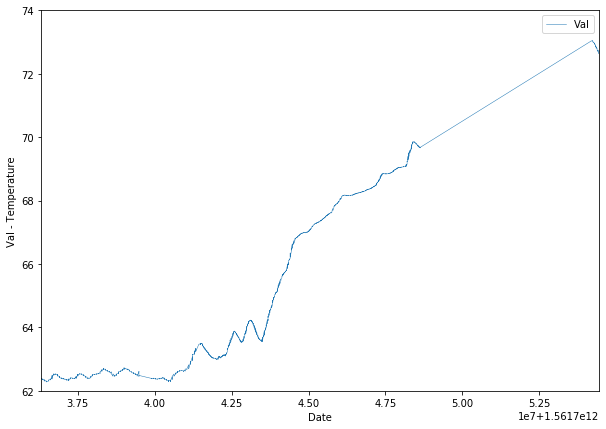

In [6]:
#df_temp = df_input[(df_input.DEVICEID == 'A101')]
#tmin = df_temp.head(1).EVT_TIMESTAMP.astype(np.int64)
#tmax = df_temp.tail(1).EVT_TIMESTAMP.astype(np.int64)
#tdiff = np.subtract(tmax, tmin) // 300000000000  # from nanosec to 5 min steps


fig, ax = plt.subplots(1, 1, figsize=(10,7))
df_temp.plot(ax=ax, lw=.5, y='Val')
ax.set_ylim(62, 74)
ax.set_xlabel('Date')
ax.set_ylabel('Val - Temperature')

In [180]:
# Fourier transform
temp_fft = sp.fftpack.fft(df_temp[['Val']])
# Spectral density (energy per frequency)
temp_psd = np.abs(temp_fft) ** 2
# return sample frequencies - roughly every 5 mins
frame_rate = 1 #/ 200  # Hz = fft_freq * frame_rate
fftfreq = sp.fftpack.fftfreq(len(temp_psd), frame_rate)
i = fftfreq > 0
#print (fftfreq)
fftfreq[i].shape

(1197,)

Text(0, 0.5, 'PSD (dB)')

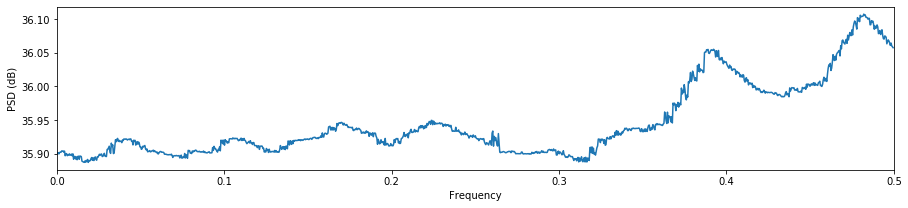

In [181]:
# Interpreting the frequency domains over the full period doesn't do the trick
fig, ax = plt.subplots(1, 1, figsize=(15,3))
ax.plot(fftfreq[i] * frame_rate, 10 * np.log10(temp_psd[i]))
#ax.plot(fftfreq[i] * frame_rate, temp_psd[i])
ax.set_xlim(0, 0.5)
#ax.set_ylim(0, 101)
ax.set_xlabel('Frequency')
ax.set_ylabel('PSD (dB)')


In [203]:
# so apply windowing first - chopping the time series into overlapping 2h windows (with 24 datapoints)
M = 24
df_temp['timestamp'] = df_temp.index
temperature = df_temp[['Val']].fillna(0).to_numpy().reshape(-1,)

#print (temperature.shape, M)
slices = skiutil.view_as_windows(temperature, window_shape=(M,))
slices.shape

hann = np.hanning(M + 1)[:-1]
slices = slices * hann
slices = slices.T
slices.shape

(24, 2373)

In [157]:
spectrum = np.fft.fft(slices, axis=0)[:M // 2 + 1:-1]
spectrum = np.abs(spectrum)

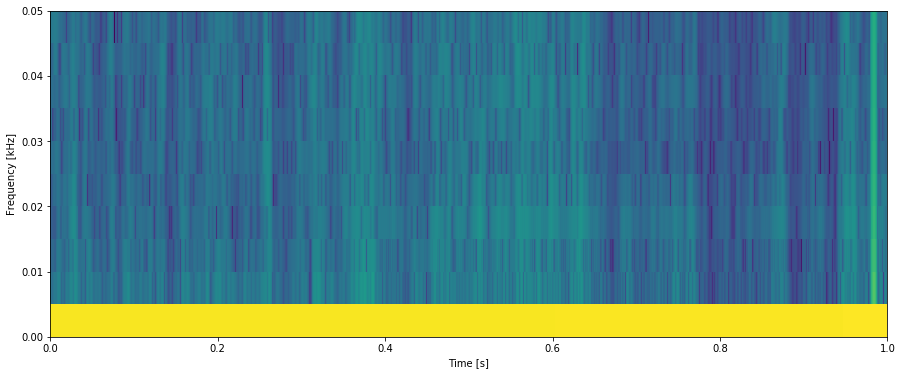

In [182]:
fig, ax = plt.subplots(1, 1, figsize=(15,6))

S = 20 * np.log10(spectrum / np.max(spectrum))

ax.imshow(S, origin='lower', cmap='viridis',
          extent=(0, 1, 0, 100 / 2 / 1000))
ax.axis('tight')
ax.set_ylabel('Frequency [kHz]')
ax.set_xlabel('Time [s]');


2019-10-08T09:53:02.184 WARNING matplotlib.legend._parse_legend_args No handles with labels found to put in legend.


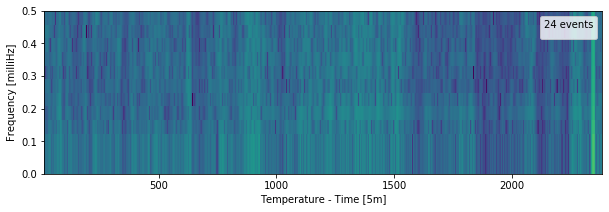

In [159]:
# this is a bit easier
from scipy import signal

rate = 1
MS = 24 # 2hours
freqsTS, timesTS, SxTS = signal.spectrogram(temperature, fs=rate, window='hanning',
                                      nperseg=MS, noverlap=MS - MS/12,
                                      detrend=False, scaling='spectrum')
# cut off frequencies too low to fit into the window the window

freqsTSb = (freqsTS > 2/MS).astype(int)

freqsTS = freqsTS * freqsTSb

#EPS = np.dot(SxPS.T, freqsPS)
#EPS = np.log10(np.dot(SxPS.T, freqsPS))
ETS = np.log10(np.dot(SxTS.T, freqsTS))

f, ax = plt.subplots(1,1,figsize=(10,3))

ax.pcolormesh(timesTS, freqsTS, 10 * np.log10(SxTS)) #, cmap='coolwarm')
ax.set_ylabel('Frequency [milliHz]')
ax.set_xlabel('Temperature - Time [5m]')
ax.legend(title='24 events')


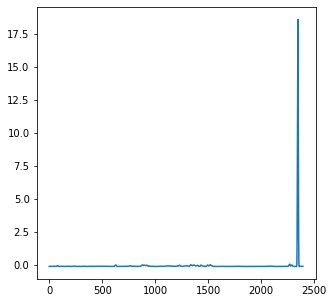

In [201]:
# compute zscore over the energy
ets_zscore = (ETS - ETS.mean())/ETS.std(ddof=0)

# absolute zscore > 3 ---> anomaly
ets_zscoreb = abs((ets_zscore > 3).astype(float) + (ets_zscore < -3).astype(float))

# make matplotlib not plot the zeroes
ets_zscoreb[ets_zscoreb == 0] = 'nan'
#ets_zscore.shape
#timesTS[1186]
timesI = np.linspace(0, temperature.size-1, temperature.size)
zscoreI = np.interp(timesI, timesTS, ets_zscore)


2019-10-08T09:53:08.804 WARNING matplotlib.legend._parse_legend_args No handles with labels found to put in legend.


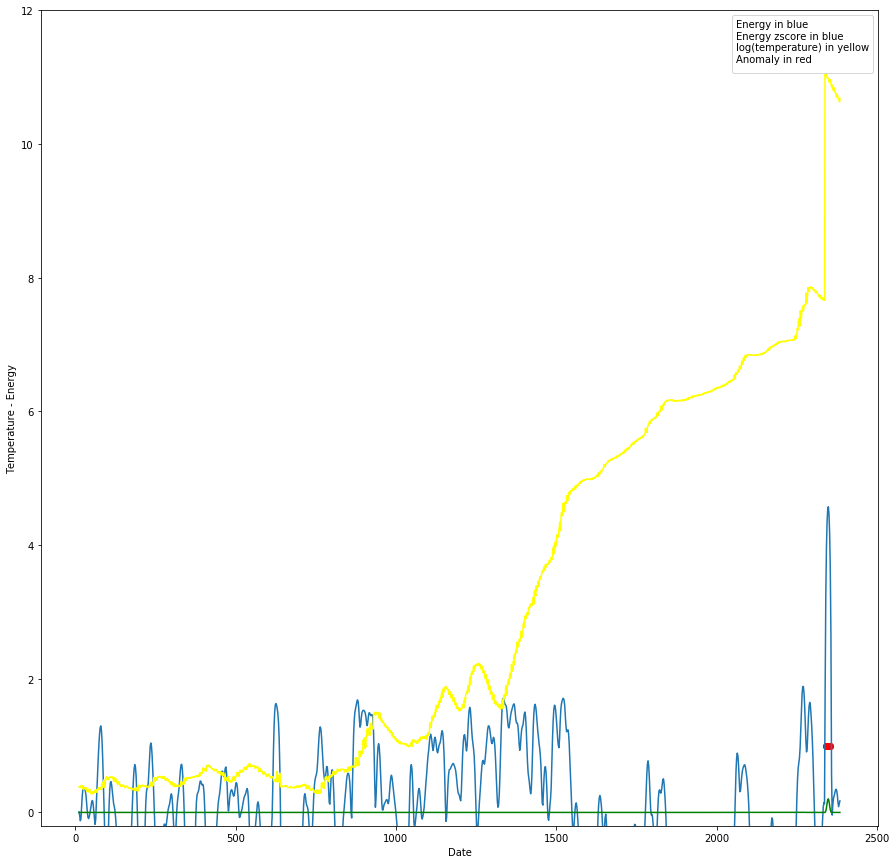

In [161]:

#ETS = np.log10(np.dot(SxTS.T, freqsTS))
ETS = np.dot(SxTS.T, freqsTS)


f, ax = plt.subplots(1,1,figsize=(15,15))

ax.plot(timesTS, ets_zscore)
ax.plot(timesTS, ETS, color = 'green')
ax.plot(np.linspace(timesTS[0],timesTS[len(timesTS)-1], len(temperature)), temperature - 62,color='yellow')
ax.set_ylim(-0.2, 12)
#ax.set_xlim(0, 930)
ax.scatter(timesTS, ets_zscoreb, color = 'red')
ax.set_xlabel('Date')
ax.set_ylabel('Temperature - Energy')
ax.legend(title='Energy in blue\nEnergy zscore in blue\nlog(temperature) in yellow\nAnomaly in red')

2019-10-07T19:27:51.824 WARNING matplotlib.legend._parse_legend_args No handles with labels found to put in legend.


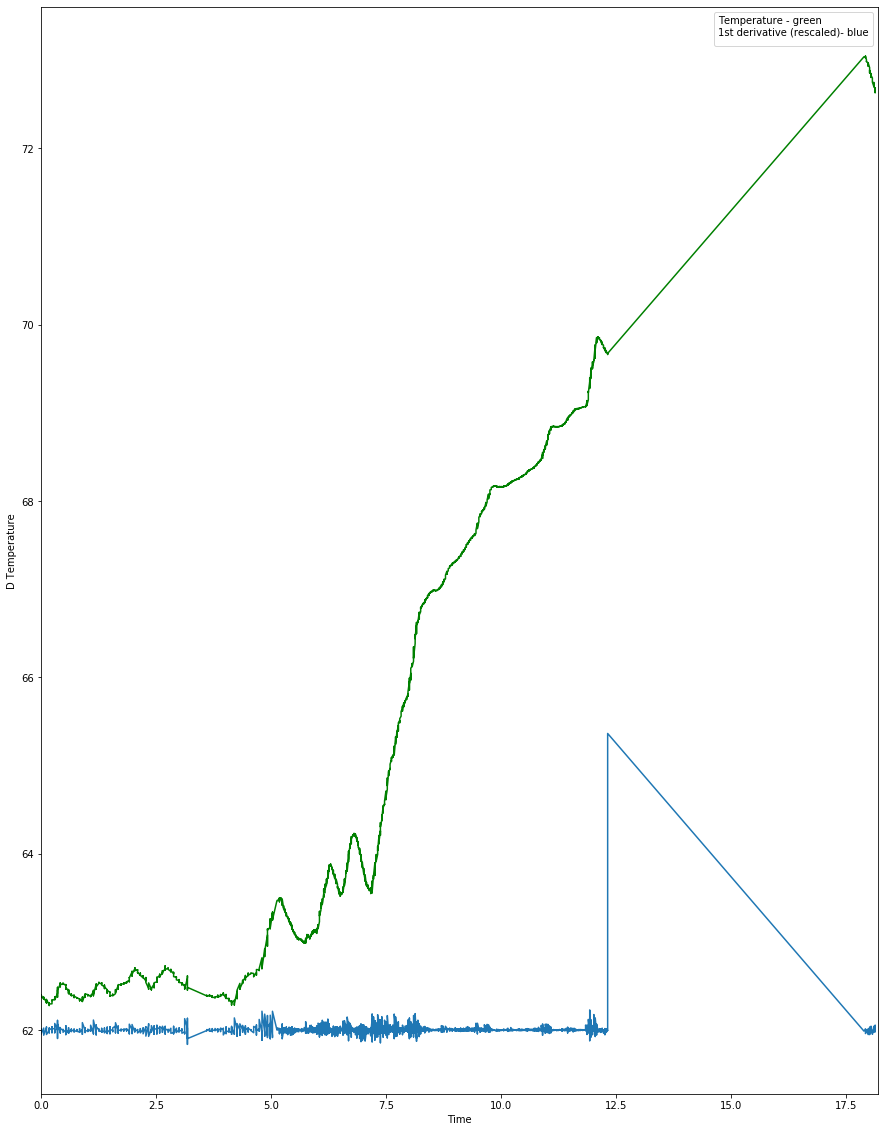

In [110]:
# look at the first discrete derivate (time)
temp_dvt = np.append(np.diff(df_temp['Val']),0)
temp_t = df_temp['Val'].values
temp_dt = (df_temp.index.values.astype(np.int64) - 1561736302064 )/ 1000000

fig, ax = plt.subplots(1, 1, figsize=(15,20))

ax.plot(temp_dt, temp_dvt + 62)
ax.plot(temp_dt, temp_t, color='green')
ax.set_xlim(0, 18.2)
ax.set_xlabel('Time')
ax.set_ylabel('D Temperature')
ax.legend(title='Temperature - green \n1st derivative (rescaled)- blue')

In [16]:
from pyod.models.knn import KNN
from pyod.models.cblof import CBLOF
#knn = KNN()
cblof = CBLOF(n_clusters=30, n_jobs=-1)
#pred = knn.fit_predict(temp_dvt.reshape(-1,1))
cblof.fit(temp_t.reshape(-1,1))
pred = cblof.predict(temp_t.reshape(-1,1))


In [17]:
l_dvt = temp_t * pred
l_dvt[l_dvt == 0] = 'nan'

SPSS_CUTOFF = 2.0  # Disregard anomaly indices smaller than this value
spss_dvt = df_temp['$O-AnomalyIndex'].values

spss_dvt[spss_dvt < SPSS_CUTOFF] = 0
spss_dvt[spss_dvt !=0] = 1
spss_dvt = temp_t * spss_dvt
spss_dvt[spss_dvt == 0] = 'nan'
                        

2019-10-07T18:25:04.984 WARNING matplotlib.legend._parse_legend_args No handles with labels found to put in legend.


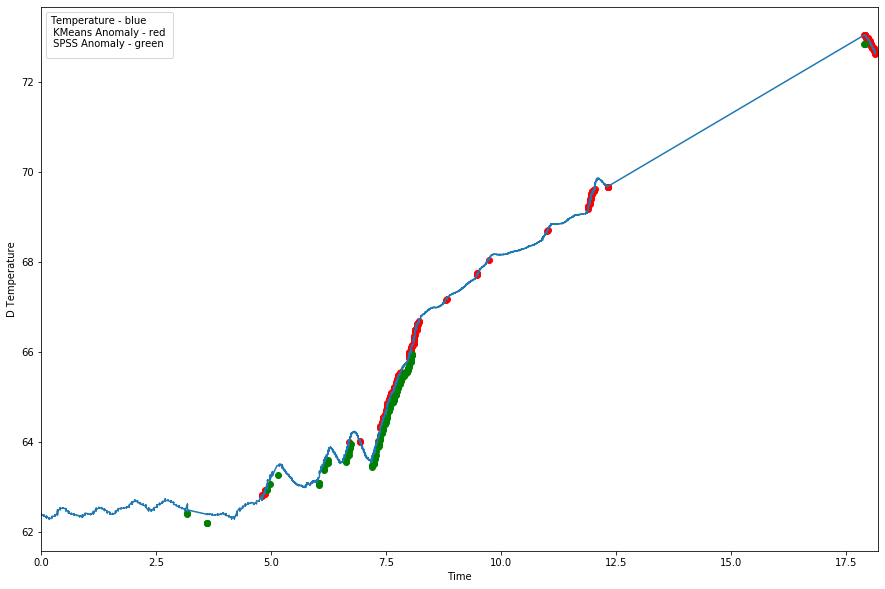

In [50]:
# KNN is not really suitable it seems, but zscore would definitively do
fig, ax = plt.subplots(1, 1, figsize=(15,10))
ax.plot(temp_dt, temp_t)
ax.scatter(temp_dt, l_dvt, color = 'red')
ax.scatter(temp_dt, spss_dvt-0.2, color='green')

ax.set_xlim(0, 18.2)
ax.set_xlabel('Time')
ax.set_ylabel('D Temperature')
ax.legend(title='Temperature - blue\n KMeans Anomaly - red \n SPSS Anomaly - green')


In [79]:
# Maybe windowing makes more sense - we have slices prepared in a previous step
# now we compare the 'shapes' of short functions
# Window size: 12
slices2 = skiutil.view_as_windows(temperature, window_shape=(12,))
slices2.shape

(2385, 12)

In [103]:

cblofwin = CBLOF(n_clusters=40, n_jobs=-1)
cblofwin.fit(slices2)
predwin = cblofwin.predict(slices2)
preddec = cblofwin.decision_function(slices2)

# prepare scatterplot
predwin[predwin != 0] = 1
pred_t = predwin * temp_t[6:2391]
pred_t[pred_t == 0] = 'nan'
predwin2 = preddec
predwin2[predwin2 < 0.5] = 0
predwin2[predwin2 !=0] = 1
predwin2 = temp_t[6:2391] * predwin2
predwin2[predwin2 == 0] = 'nan'
predwin2.shape

(2385,)

2019-10-07T19:25:57.511 WARNING matplotlib.legend._parse_legend_args No handles with labels found to put in legend.


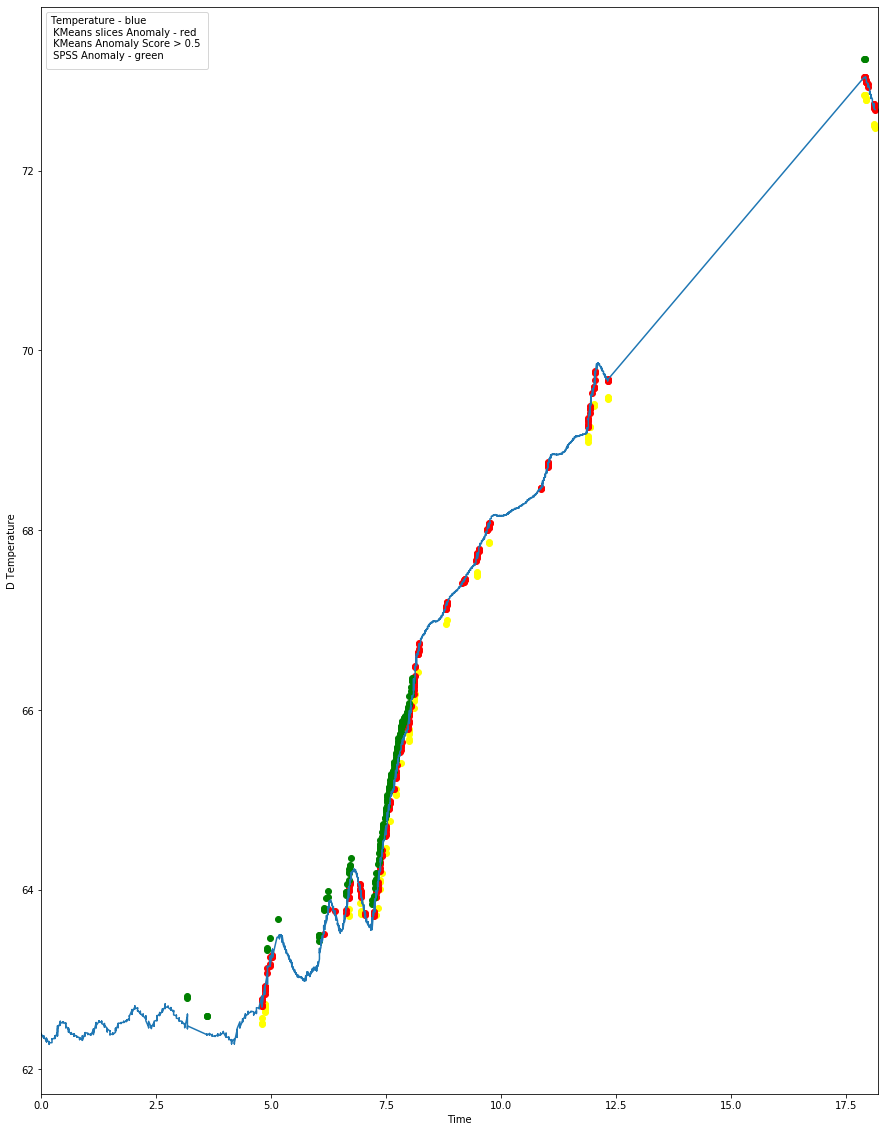

In [104]:
# KNN is not really suitable it seems, but zscore would definitively do
fig, ax = plt.subplots(1, 1, figsize=(15,20))
ax.plot(temp_dt[6:2391], temp_t[6:2391])
ax.scatter(temp_dt[6:2391], predwin2-0.2, color='yellow')
ax.scatter(temp_dt[6:2391], pred_t, color = 'red')
ax.scatter(temp_dt[6:2391], spss_dvt[6:2391]+0.2, color='green')

ax.set_xlim(0, 18.2)
ax.set_xlabel('Time')
ax.set_ylabel('D Temperature')
ax.legend(title='Temperature - blue\n KMeans slices Anomaly - red \n KMeans Anomaly Score > 0.5 \n SPSS Anomaly - green')
